In [31]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, plot_roc_curve, plot_confusion_matrix

from copy import copy

from time import time

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/us census data.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0,<=50K


In [4]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,48842.0,NaN,NaN,NaN,38.643585,13.71051,17.0,28.0,37.0,48.0,90.0
workclass,48842,7,Private,33906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,48842.0,NaN,NaN,NaN,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital-status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,48842,15,Prof-specialty,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,48842,6,Husband,19716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,48842,5,White,41762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,48842,2,Male,32650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours-per-week,48842.0,NaN,NaN,NaN,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [5]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

ordinal_encoder = OrdinalEncoder(dtype=int)
label_encoder = LabelEncoder()

X_cat = X.iloc[:,np.where(X.dtypes == object)[0]]

X_enc_cat = ordinal_encoder.fit_transform(X_cat)
X_enc = copy(X)
X_enc.iloc[:,np.where(X.dtypes == object)[0]] = X_enc_cat
y_enc = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc,y_enc,test_size=0.2, random_state=1)

In [6]:
scoring = {'accuracy': make_scorer(accuracy_score)}

parameters = {
    "learning_rate": [0.05, 0.1, 0.2, 0.5],
    "max_depth":[3,4,5],
    "n_estimators": [100,200,300,400,500]
}

gbc_gs = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

gbc_gs.fit(X_train_enc, y_train_enc)
gbc_df = pd.DataFrame.from_dict(gbc_gs.cv_results_)

In [7]:
def get_best_params(cf_results_df):
    max_ind = cf_results_df['mean_test_accuracy'].argmax()
    thresh = cf_results_df['mean_test_accuracy'][max_ind] - cf_results_df['std_test_accuracy'][max_ind]
    min_ind = cf_results_df[cf_results_df['mean_test_accuracy'] >= thresh]['mean_fit_time'].argmin()
    return cf_results_df['params'][min_ind]

In [8]:
get_best_params(gbc_df)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

In [20]:
start = time()
gbc = GradientBoostingClassifier(learning_rate=0.1,max_depth=4,n_estimators=200)
gbc.fit(X_train_enc,y_train_enc)
end = time()
print("Fitting time: ",end-start)

Fitting time:  9.212377548217773


In [89]:
def evaluate_model(model,X_test,y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:",accuracy_score(y_test,y_pred))
    plot_roc_curve(model,X_test,y_test)
    plot_confusion_matrix(model, X_test, y_test,normalize='true')

Accuracy: 0.8724536800081891


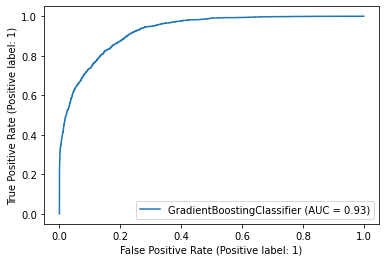

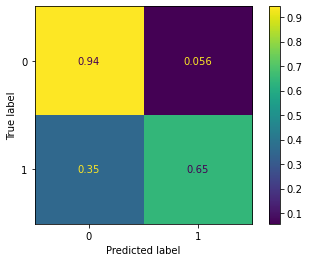

In [91]:
evaluate_model(gbc,X_test_enc,y_test_enc)

In [12]:
import catboost as cb

In [14]:
cat_features_indices = np.where(X_train.dtypes == object)[0]
cbc = cb.CatBoostClassifier(logging_level='Silent',eval_metric = 'Accuracy',cat_features=cat_features_indices)

scoring = {'accuracy': make_scorer(accuracy_score)}

parameters = {
    "max_depth":[2,3,4,5,6,7,8],
    "n_estimators": [100,200,300,400,500]
}
cbc_gs = GridSearchCV(cbc, parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

cbc_gs.fit(X_train, y_train)
cbc_df=pd.DataFrame.from_dict(cbc_gs.cv_results_)

In [15]:
get_best_params(cbc_df)

{'max_depth': 2, 'n_estimators': 500}

In [71]:
train_dataset = cb.Pool(X_train,y_train,cat_features=cat_features_indices)
test_dataset = cb.Pool(X_test,y_test,cat_features=cat_features_indices)

start = time()
cbc = cb.CatBoostClassifier(logging_level='Silent',
                              cat_features=cat_features_indices,
                              depth=2,
                              iterations=500,
                              eval_metric='Accuracy'
                              )
cbc.fit(train_dataset,eval_set=test_dataset,plot=False)
end = time()
print("Fitting time: ",end-start)

Fitting time:  9.17000150680542


Accuracy: 0.8714300337803256


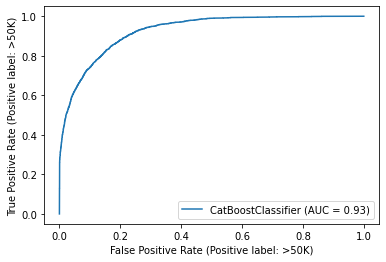

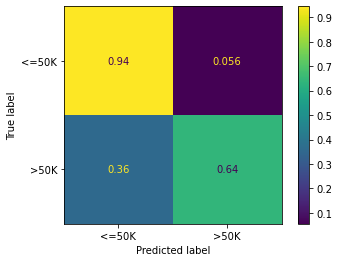

In [90]:
evaluate_model(cbc,X_test,y_test)